# PuGo Modeling
## Step 2: Enrollment Predictions

The purpose of this script is to take clean data from Step 1 and generate a predictive model. The (clean) data will be taken and first features will be engineered/generated. Then, gradient boosting will be used to create a predictive model of student enrollment.

### Goals

* Take clean data and generate features of interest
* Create gradient-boosting model for predictions
* Export model and related data needed later

### Process

* A. Load data and modules
* B. Set option flags
* C. Create derived features (feature engineering part 1) 
* D. Dummify and generate combinatorial features (feature engineering part 2)
* E. Split into training and test sets and normalize
* F. Run gradient boosting classifier
* G. Evaluate the results for accuracy
* H. Export results


### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load data and modules
### Part A1 - Load modules

In [1]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer, PolynomialFeatures
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split

from imblearn.over_sampling import SMOTE 

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Python27\Lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Part A2 - Load data

In [2]:
df = pd.read_csv('../preprocessing/pugoDataClean.csv') #only data needed. Should be output from preprocessing script

In [3]:
#These are tuition amounts for each year, non-resident. 
#http://opb.washington.edu/sites/default/files/opb/Tuition/2016-17%20Tuition%20%26%20Fee%20History.pdf

df.loc[df.ApplYr == 2010, 'Tuition'] = 25329
df.loc[df.ApplYr == 2011, 'Tuition'] = 28058
df.loc[df.ApplYr == 2012, 'Tuition'] = 29938
df.loc[df.ApplYr == 2013, 'Tuition'] = 31971
df.loc[df.ApplYr == 2014, 'Tuition'] = 33513
df.loc[df.ApplYr == 2015, 'Tuition'] = 34143
df.loc[df.ApplYr == 2016, 'Tuition'] = 34791
df.loc[df.ApplYr == 2017, 'Tuition'] = 35538

In [4]:
df_backup = df.copy(deep=True)

### Part A3 - Sanity checks

In [5]:
# Look at the columns in the data
df.columns

Index([u'ApplYr', u'Enrolled', u'Admitted', u'PuGoOffer',
       u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation',
       ...
       u'ed_3', u'ed_4', u'ed_5', u'ed_6', u'ed_1m', u'ed_2m', u'ed_3m',
       u'ed_4m', u'ed_5m', u'AcademicScore_imputed'],
      dtype='object', length=108)

In [6]:
#make sure all this is as expected
print len(df)

71699


In [7]:
print len(df[df.Admitted == 1])
print len(df[df.Enrolled == 1])

34874
5081


In [8]:
df.groupby('ApplYr').Enrolled.mean() #mean enrollment rates, regardless of admittance

ApplYr
2014    0.092415
2015    0.087651
2016    0.057361
2017    0.057714
Name: Enrolled, dtype: float64

In [9]:
df.HolisticAcademicScore.describe() #what we'll be sorting on later

count    71699.000000
mean        11.713469
std          3.487915
min          0.000000
25%         10.000000
50%         12.000000
75%         14.000000
max         18.000000
Name: HolisticAcademicScore, dtype: float64

In [10]:
df.PuGoOffer.describe() #previous offers made to students

count    71699.000000
mean      1609.607526
std       2631.377244
min          0.000000
25%          0.000000
50%          0.000000
75%       3250.000000
max       9000.000000
Name: PuGoOffer, dtype: float64

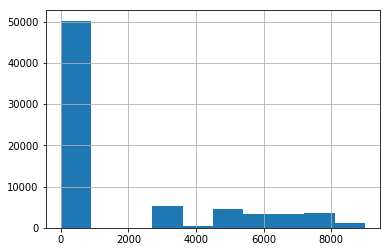

In [11]:
df.PuGoOffer.hist()

In [12]:
df.PuGoOffer.value_counts()

0       50233
3250     4781
4500     4175
5500     3384
6500     2641
7500     2630
8500     1052
8000      843
7000      619
4000      472
3000      429
5000      394
9000       46
Name: PuGoOffer, dtype: int64

## Part B - Set option flags

In [13]:
df['ApplYr'].value_counts()

2017    21676
2016    20397
2015    16349
2014    13277
Name: ApplYr, dtype: int64

### Part B1 - Set flags

Set the year
Visualize or not
Normalize or not
Simple or detailed accuracy metrics

In [14]:
only_use_admitted = False #only use admitted students in the predictions
exclude_eps = True #exclude EPS data (should almost always be True)

use_all_years = False #include all years in the analysis
year = 2017 #if the above is not true, which years to use
use_most_recent = True #instead use data from 2014-2017

check_only_last_year = 0 #used in fine-tuning cutoff for predictions. If desired, should be a single integer value for a year

use_pugo_amounts = True #include PuGo amounts in predictions (should almost always be True)

normalize_metrics = True #whether or not to scale values (should almost always be True)

drop_all_nulls = True #remove any column(s) with a null value

stratify_split = False #stratify the train-test split by class (i.e. enrolled or not)

save_results = True #save final outputs

### Part B2 - Further data cleaning

In [15]:
if not use_all_years: #use years of interest based on the above option flags
    if use_most_recent:
        df = df[df['ApplYr'].isin([2017, 2016, 2015, 2014])]
    else:
        df = df.loc[df['ApplYr'] == year]

df = df.reset_index(drop=True) 

df.columns[df.isnull().sum() != 0] #check that there are no columns with nulls

Index([], dtype='object')

In [16]:
if only_use_admitted: #only if using admits only
    df = df[df.Admitted == 1]

## Part C - Create derived features

### Part C1 - Tuition after grants

In [17]:
#these features are key. Essentially, we only want a single variable (tuition after grants) 
#that accounts for scholarship funds and changes thereto

if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PuGoOffer'] - df['GrantSchol']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['GrantSchol']

df.loc[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

In [18]:
df.tuition_after_grants.describe()

count    71699.000000
mean     32663.400033
std       3297.708428
min       4912.000000
25%      31038.000000
50%      34143.000000
75%      34791.000000
max      35538.000000
Name: tuition_after_grants, dtype: float64

### Part C2 - Add more features

Essentially adding more features and swapping things around. Previous versions of the code joined some of the below-created features to retention data but that has since been removed.

In [19]:
df['AcademicRankPctYr'] = df.groupby(['ApplYr'])['AcademicRank'].rank(pct = True, ascending = True)

In [20]:
df['LowerHighSchoolGPA'] = 0
df.loc[df.HS_GPA > 3.0, 'LowerHighSchoolGPA'] = 3
df.loc[df.HS_GPA > 3.4, 'LowerHighSchoolGPA'] = 3.4
df.loc[df.HS_GPA > 3.6, 'LowerHighSchoolGPA'] = 3.6
df.loc[df.HS_GPA > 3.8, 'LowerHighSchoolGPA'] = 3.8

In [21]:
df['UpperHighSchoolGPA'] = 3
df.loc[df.HS_GPA > 3, 'UpperHighSchoolGPA'] = 3.4
df.loc[df.HS_GPA > 3.4, 'UpperHighSchoolGPA'] = 3.6
df.loc[df.HS_GPA > 3.6, 'UpperHighSchoolGPA'] = 3.8
df.loc[df.HS_GPA > 3.8, 'UpperHighSchoolGPA'] = 4.0

In [22]:
data_all = df[df.TestScore > 0] #remove students with null entries here

In [23]:
pugoTuitionAndGrantData = data_all[['PuGoOffer', 'GrantSchol', 'Tuition', 'ApplYr', 'Admitted']]
data_all.drop('ApplYr', axis=1, inplace=True)
data_all.drop('GrantSchol', axis=1, inplace=True)
data_all.drop('PuGoOffer', axis=1, inplace=True)
data_all.drop('Tuition', axis=1, inplace=True)

print 'There are ' + str(data_all.HS_GPA.count()) + ' rows'

There are 71699 rows


In [24]:
if exclude_eps:
    epsCols = ['UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct']
    data_all = data_all.drop(epsCols, axis = 1, errors = 'ignore')

## Part D - Dummify and generate combinatorial features

### Part D1 - Create dummies

In [25]:
isEnrolledOrMatriculated = data_all.Enrolled.copy()

In [26]:
#removal of null values

if drop_all_nulls:
    cols = data_all.columns[data_all.isnull().any()]
    data_all = data_all.loc[~data_all[cols].isnull().any(axis = 1)]
    isEnrolledOrMatriculated = isEnrolledOrMatriculated.loc[data_all.index]

In [27]:
len(data_all)

71699

### Part D2 - Predict admissions

This was added because admissions will not have a complete list of who is and isn't admitted at the time PuGo offers are made. Though, ultimately, previous years' data was used in 2018, these predictions of admissions play a large part in downstream predictions of enrollment

In [28]:
if not only_use_admitted:
    # these predictions are made using a simple logistic regression
    parameters = {'C': [0.1, 1, 2.5, 5, 7.5, 10, 12.5, 15, 100]} #these are regularization parameters for predictions
    model = LogisticRegression()
    #train-test split
    x_train, x_test, y_train, y_test = train_test_split(data_all.drop(['Enrolled', 'Admitted'], axis = 1), data_all['Admitted'], train_size = 0.8, random_state = 42, stratify = data_all['Admitted'])

    #create a scaler to normalize data
    scalerAdmit = preprocessing.RobustScaler().fit(x_train)
    x_train = pd.DataFrame(scalerAdmit.transform(x_train))

    #search across the regularization parameters for the best one
    grid = GridSearchCV(model, parameters, scoring = 'roc_auc', cv = 5, verbose = 1)
    grid.fit(x_train, y_train)

    #prediction model for admittance
    clfAdmit = LogisticRegression(C = grid.best_params_['C'])
    clfAdmit.fit(x_train, y_train)

    #calculated values
    probs = clfAdmit.predict_proba(scalerAdmit.transform(data_all.drop(['Enrolled', 'Admitted'], axis = 1)))
    predicts = clfAdmit.predict(scalerAdmit.transform(data_all.drop(['Enrolled', 'Admitted'], axis = 1)))

    #add as features for downstream predictions
    data_all['isAdmittedProbs'] = pd.Series(probs[:,1], index = data_all.index)
    data_all['isAdmittedPredict'] = pd.Series(predicts, index = data_all.index)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.0min finished


In [29]:
check = scalerAdmit.transform(data_all.drop(['Enrolled', 'Admitted', 'isAdmittedProbs', 'isAdmittedPredict'], axis = 1))
clfAdmit.score(check, data_all['Admitted']) #check accuracy. (should be >96%)

0.9607525906916414

In [30]:
grid.best_params_ #best regularization parameter

{'C': 12.5}

In [31]:
print data_all.isAdmittedPredict.sum()
print data_all.Admitted.sum()
print data_all.isAdmittedPredict.sum() * 1.0 / data_all.Admitted.sum() #ratio of predicted admittees to actual admittees

34272
34874
0.9827378562826175


In [32]:
coefs = pd.Series(clfAdmit.coef_[0], index = data_all.drop(['Enrolled', 'Admitted', 'isAdmittedProbs', 'isAdmittedPredict'], axis = 1, errors = 'ignore').columns)
coefs.sort_values() #look at the regression coefficients for the admittance predictions

tuition_after_grants           -2.194314
HolisticAcademicScore          -1.430463
FAFSAFiledOnTime               -1.335608
Unfunded40Kplus_Fin6           -1.207561
TR_GPA_exists                  -0.915731
hs_code_50718.0                -0.823936
Unfunded40K_Fin5               -0.748967
hs_code_53218.0                -0.629864
FiledFAFSA                     -0.589409
HS_Yrs_Math                    -0.504972
Dependency                     -0.499984
Unfunded30K_Fin4               -0.474645
Unfunded0K_Fin2                -0.445480
hs_code_53343.0                -0.401254
hs_state_OR                    -0.396887
hs_state_NV                    -0.342491
entry_class_1                  -0.335705
hs_state_AZ                    -0.305431
over_20                        -0.280468
Other_Budget                   -0.266855
hs_code_53463.0                -0.261375
CollegeInTheHighSchool         -0.243081
ed_0                           -0.210300
AcademicRank                   -0.196933
hs_state_CA     

In [33]:
data_all = data_all.drop(['Admitted'], axis = 1) #this is dropped because it won't be known for the current cycle

### Part D3 - Split off matrices for predictions

In [34]:
y = data_all.Enrolled #target for predictions (just predicting enrollment here)
x = data_all.copy() #everything else

x.drop('Enrolled', axis=1, inplace=True)

### Part D4 - Create additional features

References from Dev Nambi:
* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

Note: part D4 was not found to be useful in predictions. Thus, everything is set to False here. - Lavi

In [35]:
squaredFeatures = False #if true, will square every feature and include
logFeatures = False #if true, will take log of every feature and include
expFeatures = False #if true, will exponentiate every feature and include
interactionFeatures = False #if true, will generate interaction terms and include

In [36]:
hold = x.copy()
hold = hold.drop(['tuition_after_grants'], axis = 1) #we only want a single feature associated with this!!
if squaredFeatures:
    interactionFeatures = False
    poly = PolynomialFeatures(2, interaction_only = False, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)
if logFeatures:
    tempDF = hold.copy()
    tempDF[tempDF == 0] = 0.01
    temp = np.log(abs(tempDF))
    temp.columns = ['log-' + each for each in hold.columns]
    x = x.join(temp)
if expFeatures:
    tempDF = hold.copy()
    temp = np.exp(tempDF)
    temp[temp > 10000] = 10000
    temp.columns = ['exp-' + each for each in hold.columns]
    x = x.join(temp)
if interactionFeatures:
    scoreFeatures = False
    poly = PolynomialFeatures(2, interaction_only = True, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)    

In [37]:
#remove columns with all 0s or all 1s, because constants are useless
x = x.drop(x.columns[(x == 0).all()], axis = 1)
x = x.drop(x.columns[(x == 1).all()], axis = 1)

In [38]:
x.shape #final shape - be sure this is what we expect!!

(71699, 107)

In [39]:
x.tail() #sanity check

HolisticAcademicScore  HolisticPQAScore  HolisticAdmissionScore  \
71694                      8                 8                     8.0   
71695                     10                 8                    10.0   
71696                     11                 5                    11.0   
71697                     10                 8                    10.0   
71698                     10                 4                    10.0   

       parent1_ed_level  parent2_ed_level  HighestParentalEducation  \
71694               6.0               6.0                       6.0   
71695               3.0               2.0                       3.0   
71696               6.0               5.0                       6.0   
71697               2.0               2.0                       2.0   
71698               5.0               3.0                       5.0   

       TestScore  AcademicScore  AcademicRank  HS_AI        ...          \
71694     1380.0       0.752000          1023   43.0        ...           
71695      950.0       0.922063          3578   68.0        ...           
71696     1280.0       0.842500          2292   59.0        ...           
71697     1190.0       0.736313           869   35.0        ...           
71698      796.0       0.682125           444   70.0        ...           

       ed_3m  ed_4m  ed_5m  AcademicScore_imputed  tuition_after_grants  \
71694      1      1      1               0.752000                 35538   
71695      1      0      0               0.922063                 35538   
71696      1      1      1               0.842500                 35538   
71697      0      0      0               0.736313                 35538   
71698      1      1      1               0.756750                 35538   

       AcademicRankPctYr  LowerHighSchoolGPA  UpperHighSchoolGPA  \
71694           0.092176                 0.0                 3.0   
71695           0.653188                 3.8                 4.0   
71696           0.308406                 3.0                 3.4   
71697           0.073468                 0.0                 3.0   
71698           0.030195                 3.0                 3.4   

       isAdmittedProbs  isAdmittedPredict  
71694         0.000373                  0  
71695         0.000977                  0  
71696         0.023128                  0  
71697         0.000016                  0  
71698         0.005345                  0  

[5 rows x 107 columns]

## Part E - Split into training and test sets and normalize

1. Come up with interaction terms
2. Use a 80-20 split

### Part E1 - Split in a 80-20 split

In [40]:
len(x)

71699

In [41]:
y.value_counts()

0    66618
1     5081
Name: Enrolled, dtype: int64

In [42]:
# create training and testing split for predictions
if stratify_split == True:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42, stratify=y)
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42)

print 'x_train has ' + str(len(x_train)) + ' observations'
print 'y_train has ' + str(len(y_train)) + ' observations'
print 'x_test has ' + str(len(x_test)) + ' observations'
print 'y_test has ' + str(len(y_test)) + ' observations'


x_train has 57359 observations
y_train has 57359 observations
x_test has 14340 observations
y_test has 14340 observations


In [43]:
#Note - this was moved here from Dev's code. Scaling should be done after train/test split and using train data as a basis! - Lavi

if normalize_metrics:
    print 'Normalized'
    scaler = preprocessing.RobustScaler().fit(x_train) #Lavi - swapped to robust scaler
    x_train = pd.DataFrame(scaler.transform(x_train), index = x_train.index, columns = x_train.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), index = x_test.index, columns = x_test.columns)

Normalized


### Part E2 - Use SMOTE

Note: Part E2 was not found to be useful in predictions - Lavi

More on SMOTE, if it is of interest: https://arxiv.org/abs/1106.1813

In [44]:
smote = False

if smote:
    sm = SMOTE(random_state = 11)
    colX = x_train.columns
    indX = x_train.index
    colY = y_train.name
    indY = y_train.index
    x_train, y_train = sm.fit_sample(x_train, y_train)
    x_train = pd.DataFrame(x_train, columns = colX)
    y_train = pd.Series(y_train, name = colY)

In [45]:
y_train.value_counts()

0    53310
1     4049
Name: Enrolled, dtype: int64

In [46]:
#export data and use in cross validation scripts (optional)
x_train.join(y_train).to_csv('train.csv')

## Part F - Run gradient boosting classifier

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


In [47]:
# This is where the enrollment predictions are finally made. Parameters can be tuned using the cross validation script, if desired.
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, verbose=1) #options/params

clf.fit(x_train, y_train) #fit model
#
probs = clf.predict_proba(x_train) #make predictions
predicts = clf.predict(x_train)
#
probs_test = clf.predict_proba(x_test)
predicts_test = clf.predict(x_test)

      Iter       Train Loss   Remaining Time 
         1           0.4944            4.38m
         2           0.4828            4.50m
         3           0.4737            4.67m
         4           0.4662            4.59m
         5           0.4598            4.55m
         6           0.4539            4.54m
         7           0.4488            4.53m
         8           0.4442            4.51m
         9           0.4405            4.49m
        10           0.4370            4.49m
        20           0.4173            4.42m
        30           0.4095            4.09m
        40           0.4028            3.96m
        50           0.3995            3.76m
        60           0.3956            3.67m
        70           0.3929            3.54m
        80           0.3900            3.45m
        90           0.3875            3.36m
       100           0.3853            3.30m
       200           0.3702            2.79m
       300           0.3599            2.39m
       40

In [48]:
fi = enumerate(clf.feature_importances_)
cols = x_train.columns
sorted([(value*100, cols[i]) for (i,value) in fi if value > 0.001], reverse=True)[:100] #get a list of important coefficients

[(9.508933152251872, 'Income'),
 (9.467435881138602, 'isAdmittedProbs'),
 (9.07488647902163, 'PLUSLoans'),
 (8.567711382527781, 'EFC'),
 (6.44468880838719, 'AgeDecimal'),
 (5.734994180759213, 'tuition_after_grants'),
 (4.523604037163705, 'AcademicRank'),
 (3.678785015481092, 'TestScore'),
 (2.991111976528681, 'AcademicRankPctYr'),
 (2.6545366804848576, 'AcademicScore_imputed'),
 (2.345175634899056, 'NonPLUSLoans'),
 (2.1022249369685744, 'WorkAndLoansNoPLUS'),
 (2.0040080300704504, 'HolisticPQAScore'),
 (1.953842994260431, 'HS_AI'),
 (1.6682769153119767, 'AcademicScore'),
 (1.6265403295052958, 'HolisticAdmissionScore'),
 (1.465581456694061, 'HS_GPA'),
 (1.2933136133789527, 'Athlete'),
 (1.2324022562344357, 'HS_Yrs_Soc_Sci'),
 (1.173009671232557, 'HolisticAcademicScore'),
 (1.1488531647860674, 'HS_Yrs_For_Lang'),
 (0.9008650412070953, 'hs_state_CA'),
 (0.8726472005847595, 'HS_Yrs_Science'),
 (0.8004588991745434, 'HS_For_Lang_Yrs'),
 (0.7752810153346076, 'HS_Yrs_Arts'),
 (0.67110523173513

## Part G - Evaluate the results for accuracy

### Part G1 - Look at the accuracy scores lift

In [49]:
# In general, it is possible to get perfect accuracy with GBM without too much overfitting. Next cell is more important
print 'Baseline training accuracy is ' + str(1.0-y_train.mean())
print 'Training score is ' + str(clf.score(x_train, y_train))
print 'Improvement above the training baseline is ' + str((clf.score(x_train, y_train)) - (1.0-y_train.mean()))
print 'Percent improvement above the training baseline is ' + str(((clf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

Baseline training accuracy is 0.9294095085339702
Training score for is 0.9422409735176694
Improvement above the training baseline is 0.012831464983699248
Percent improvement above the training baseline is 0.18177327735243395


In [50]:
# Been able to get test accuracy around 92-94%
print 'Baseline test accuracy is ' + str(1.0-y_test.mean())
print 'Test score is ' + str(clf.score(x_test, y_test))
print 'Improvement above the test baseline is ' + str((clf.score(x_test, y_test)) - (1.0-y_test.mean()))
print 'Percent improvement above the test baseline is ' + str(((clf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

Baseline test accuracy is 0.9280334728033472
Test score for is 0.9322175732217574
Improvement above the test baseline is 0.004184100418410108
Percent improvement above the training baseline is 0.05813953488372185


In [51]:
#don't be surprised if these are very low
print 'Total predicted yield is: ' + str(clf.predict(x_train.append(x_test)).sum()) + ' students'
print 'Actual yield is: ' + str(isEnrolledOrMatriculated.sum()) + ' students'

Total predicted yield is: 1046 students
Actual yield is: 5081 students


In [52]:
#don't be surprised if these are very low
print 'Predicted test yield is: ' + str(clf.predict(x_test).sum()) + ' students'
print 'Actual test yield is: ' + str(y_test.sum()) + ' students'

Predicted test yield is: 176 students
Actual test yield is: 1032 students


### Part G2 - Look at the ROC/AUC scores

For more, see: http://gim.unmc.edu/dxtests/roc3.htm

In [53]:
# Not a surprise if perfect
print 'Training Set AUC: ' + str(metrics.roc_auc_score(y_train, probs[:, 1]))

Training Set AUC: 0.9276640093389832


In [54]:
# High has been about 0.85
print 'Test Set AUC: ' + str(metrics.roc_auc_score(y_test, probs_test[:, 1]))

Test Set AUC: 0.8473459311063114


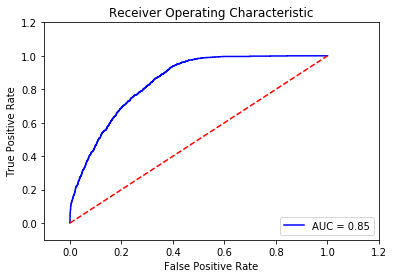

In [55]:
# Compute the FPR, TPR
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

# Plot an ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part G3 - Look at the initial confusion matrix

I'd recommend looking more into this if better predictions are desired

In [56]:
def getMetrics(y_actual, y_pred, string = False):
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    true_positive = confusion[1][1] # student enrolled and we predicted they would enroll
    false_positive = confusion[0][1] # student enrolled and we predicted they wouldn't enroll
    true_negative = confusion[0][0] # student didn't enroll and we predicted they wouldn't enroll
    false_negative = confusion[1][0] # student didn't enroll and we predicted they would enroll
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    fscore = metrics.f1_score(y_actual, y_pred)
    output = {}
    if string:
        output = {'precision': str(precision), 
            'recall': str(recall), 
            'f_score': str(fscore), 
            'tp': str(true_positive), 
            'fp': str(false_positive), 
            'tn': str(true_negative), 
            'fn': str(false_negative)}
    else:
        output = {'precision': precision, 
            'recall': recall, 
            'f_score': fscore, 
            'tp': true_positive, 
            'fp': false_positive, 
            'tn': true_negative, 
            'fn': false_negative}
    return output

In [57]:
def generateReportString(metrics):
    output = 'Of the ' + str(metrics['tp'] + metrics['fn']) + ' students who enrolled at the UW, we correctly predicted '
    output = output + str(metrics['tp']) + ' of them.\n'
    output = output + 'Of the ' + str(metrics['tp'] + metrics['fp']) + ' students who we predicted would enroll at the UW, '
    output = output + str(metrics['tp']) + ' of them did\n'
    output = output + 'True positives: ' + str(metrics['tp']) + '; False positives: ' + str(metrics['fp']) + '\n'
    output = output + 'True negatives: ' + str(metrics['tn']) + '; False negatives: ' + str(metrics['fn']) + '\n'
    return output

In [58]:
y_array = np.array(y_train)
metricCalcs = getMetrics(y_array, predicts)

print generateReportString(metricCalcs)

Of the 4049 students who enrolled at the UW, we correctly predicted 803 of them.
Of the 870 students who we predicted would enroll at the UW, 803 of them did
True positives: 803; False positives: 67
True negatives: 53243; False negatives: 3246



In [59]:
# Now do it for the TEST set
y_array = np.array(y_test)
metricCalcs = getMetrics(y_array, predicts_test)

print generateReportString(metricCalcs)
p = metricCalcs['precision']
r = metricCalcs['recall']

Of the 1032 students who enrolled at the UW, we correctly predicted 118 of them.
Of the 176 students who we predicted would enroll at the UW, 118 of them did
True positives: 118; False positives: 58
True negatives: 13250; False negatives: 914



### Part G4 - Find the best thresholds, F-Score optimize

In [60]:
def change_cutpoint(new_threshold, probs):
    array_to_return = np.zeros(len(probs))
    for index, value in enumerate(probs):
        if value >= new_threshold:
            array_to_return[index] = 1
    return array_to_return

In [61]:
def generateOutputString(cutoff, metrics, students):
    output = 'Cutoff: ' + str(cutoff) + '; Predicted Enrollments: ' + str(students)
    output = output + ' -- Precision: ' + metrics['precision'] + '; Recall: ' + metrics['recall']
    output = output + '; F-score: ' + metrics['f_score'] + '; True Pos: ' + metrics['tp'] + '; False Pos: ' + metrics['fp']
    output = output + '; True Neg: ' + metrics['tn'] + '; False Neg: ' + metrics['fn']
    return output

In [62]:
#here, the threshold for classification is changed to get results that are similar to actual in terms of enrollment counts.
#it should be understood that this is coming at the expense of precision/recall, depending on how this is tweaked

y_array = np.array(y_test)
y_enrolled = y_test.sum()
best = 0 #initial best value

flag = True
for number in range(100): #increment by 0.01
    cutoff = number / 100.0
    new_predictions = change_cutpoint(cutoff, probs_test[:, 1]) #generate predictions based on this
    metricCalcs = getMetrics(y_array, new_predictions, string = True)
    students = len(new_predictions[new_predictions >= cutoff]) #number of predicted enrollees
    if students <= y_enrolled and flag: #if predicted is greater than actual
        best = cutoff
        flag = False #stop the loop and store the value
    print generateOutputString(cutoff, metricCalcs, students)

Cutoff: 0.0; Predicted Enrollments: 14340 -- Precision: 0.07196652719665272; Recall: 1.0; F-score: 0.13427010148321625; True Pos: 1032; False Pos: 13308; True Neg: 0; False Neg: 0
Cutoff: 0.01; Predicted Enrollments: 8229 -- Precision: 0.1241949204034512; Recall: 0.9903100775193798; F-score: 0.22071050642479215; True Pos: 1022; False Pos: 7207; True Neg: 6101; False Neg: 10
Cutoff: 0.02; Predicted Enrollments: 7458 -- Precision: 0.13555913113435236; Recall: 0.9796511627906976; F-score: 0.2381625441696113; True Pos: 1011; False Pos: 6447; True Neg: 6861; False Neg: 21
Cutoff: 0.03; Predicted Enrollments: 6951 -- Precision: 0.14314487124154798; Recall: 0.9641472868217055; F-score: 0.24927971940373292; True Pos: 995; False Pos: 5956; True Neg: 7352; False Neg: 37
Cutoff: 0.04; Predicted Enrollments: 6490 -- Precision: 0.15069337442218797; Recall: 0.9476744186046512; F-score: 0.2600372241425153; True Pos: 978; False Pos: 5512; True Neg: 7796; False Neg: 54
Cutoff: 0.05; Predicted Enrollmen

Cutoff: 0.43; Predicted Enrollments: 239 -- Precision: 0.5606694560669456; Recall: 0.1298449612403101; F-score: 0.2108575924468922; True Pos: 134; False Pos: 105; True Neg: 13203; False Neg: 898
Cutoff: 0.44; Predicted Enrollments: 233 -- Precision: 0.575107296137339; Recall: 0.1298449612403101; F-score: 0.21185770750988142; True Pos: 134; False Pos: 99; True Neg: 13209; False Neg: 898
Cutoff: 0.45; Predicted Enrollments: 223 -- Precision: 0.5919282511210763; Recall: 0.12790697674418605; F-score: 0.2103585657370518; True Pos: 132; False Pos: 91; True Neg: 13217; False Neg: 900
Cutoff: 0.46; Predicted Enrollments: 214 -- Precision: 0.5981308411214953; Recall: 0.12403100775193798; F-score: 0.20545746388443017; True Pos: 128; False Pos: 86; True Neg: 13222; False Neg: 904
Cutoff: 0.47; Predicted Enrollments: 201 -- Precision: 0.6169154228855721; Recall: 0.12015503875968993; F-score: 0.20113544201135442; True Pos: 124; False Pos: 77; True Neg: 13231; False Neg: 908
Cutoff: 0.48; Predicted 

Cutoff: 0.87; Predicted Enrollments: 21 -- Precision: 0.8571428571428571; Recall: 0.01744186046511628; F-score: 0.034188034188034185; True Pos: 18; False Pos: 3; True Neg: 13305; False Neg: 1014
Cutoff: 0.88; Predicted Enrollments: 17 -- Precision: 0.8235294117647058; Recall: 0.013565891472868217; F-score: 0.02669208770257388; True Pos: 14; False Pos: 3; True Neg: 13305; False Neg: 1018
Cutoff: 0.89; Predicted Enrollments: 16 -- Precision: 0.875; Recall: 0.013565891472868217; F-score: 0.026717557251908396; True Pos: 14; False Pos: 2; True Neg: 13306; False Neg: 1018
Cutoff: 0.9; Predicted Enrollments: 14 -- Precision: 0.8571428571428571; Recall: 0.011627906976744186; F-score: 0.022944550669216062; True Pos: 12; False Pos: 2; True Neg: 13306; False Neg: 1020
Cutoff: 0.91; Predicted Enrollments: 12 -- Precision: 0.8333333333333334; Recall: 0.009689922480620155; F-score: 0.019157088122605366; True Pos: 10; False Pos: 2; True Neg: 13306; False Neg: 1022
Cutoff: 0.92; Predicted Enrollments:

In [63]:
if check_only_last_year > 0: #if more fine-grain tuning of the cutpoint is desired, can use only previous year's results
    probs_test_new = pd.DataFrame({'Prob': probs_test[:,1]}, index = y_test.index)
    probs_test_new['Year'] = pugoTuitionAndGrantData.ApplYr
    probs_test_new = probs_test_new[probs_test_new.Year == check_only_last_year].Prob
    enrolled = y_test[y_test.index.isin(probs_test_new.index)].sum()
else:
    probs_test_new = probs_test[:,1]
    enrolled = y_enrolled
    
flag = True
step = 0.01
for number in np.arange(best - 0.1, best + 0.1, step):
    new_predictions = change_cutpoint(number, probs_test_new)
    students = len(new_predictions[new_predictions >= cutoff])
    if students <= enrolled and flag:
        best = number
        flag = False

In [64]:
best

0.22000000000000008

In [65]:
#adjusted yield should be much closer to actual
print 'Total adjusted yield is: ' + str((clf.predict_proba(x_train.append(x_test))[:,1] > best).sum()) + ' students'
print 'Actual yield is: ' + str(isEnrolledOrMatriculated.sum()) + ' students'

Total adjusted yield is: 4856 students
Actual yield is: 5081 students


In [66]:
best = int(best * 1000)
best = best * 1.0 / 1000

y_enrolled, best

(1032, 0.22)

Dev stored his results in this Google sheet, if it's of interest. https://docs.google.com/a/uw.edu/spreadsheets/d/1ne3dhmafyKZQNlTm7dlONYXvflGP-r3K-CeHfnOO6Qw/edit?usp=sharing 


## Part H - Export results

* Use pickle, https://docs.python.org/2/library/pickle.html 

In [67]:
if save_results: #save prediction model
    output_name = 'forOpt/boosting_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved model'

Saved model


In [68]:
if save_results: #save values that are later used in addition to modeling
    pugoTuitionAndGrantData.to_csv('forOpt/pugoTuitionAndGrants.csv', index=False)
    print 'Saved pugo and grant amounts'

Saved pugo and grant amounts


In [69]:
if save_results: #save data
    x.join(y, rsuffix = '_r').to_csv('forOpt/data_all.csv', index=False)
    print 'Saved transformed data set'

Saved transformed data set


In [70]:
if save_results: #save scaler (to use if/when re-scaling)
    scaler_file = 'forOpt/scaler.pkl'
    with open(scaler_file, 'wb') as output:
        pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved scaler'

Saved scaler


In [71]:
if save_results: #save column names
    output_name = 'forOpt/columns.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(x.columns, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved columns'

Saved columns


In [72]:
if save_results: #save best cutoff value
    output_name = 'forOpt/best_cutoff.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(best, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved cutoff'

Saved cutoff
